In [1]:
import numpy as np
import time
from os import getcwd, path
from pathlib import Path
import pandas as pd

# np load error fix
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

from sys import path as sp
sp.append(path.join((Path.cwd()).parent,"scripts"))


In [2]:
from pynq import Overlay
from pynq import allocate
from filepaths import paths
import pynq

root = getcwd()
BIT = path.join(paths.get('BITS_DIR'), 'cnn-mix-moretrng.bit')
model_bitstream = 'cnn-mix-moretrng.bit'

# Initialisation

outputs: <br>
0: Grenade
1: Reload
2: Exit
3: Shield
4: IDLE
5: IGNORE

In [4]:
from filepaths import paths
from start_detector import Detector

In [5]:
fpga_detector = Detector(model_bitstream)

/home/xilinx/jupyter_notebooks/capstoneml/mlp_bitstreams_testing/cnn_mix_moretrng.bit


# Live Testing

In [3]:
overlay = Overlay(BIT)
dma = overlay.axi_dma_0

in_buffer0 = allocate(shape=(120,), dtype=np.float32)
out_buffer0 = allocate(shape=(5,), dtype=np.float32)

In [1]:
# Constant stream of 6 datapoints
input_stream = []
state_of_game = True # In Gameplay
predicted_outcome = ["exit", "grenade", "idle", "reload", "shield"]
prev_detect = ""
while (state_of_game):
    out_idx = fpga_detector.eval_data(input_stream)
    print(predicted_outcome[out_idx])
    if out_idx != 2:
        prev_detect = out_idx
    print(prev_detect)
    # Do whatever with outcome

NameError: name 'fpga_detector' is not defined

# Run on prerecorded Data (Pre-live implementation of sensor)

In [6]:
from dataloader import get_real_testdata, load_to_df, unlink_DStore
from modelling_utils import scale_vals

In [15]:
testfiles=get_real_testdata()
train_cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'Activity_code']
test_cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'Activity_code']
targetfiles = testfiles
cols = test_cols

# targetfiles = unlink_DStore(targetfiles)
targetfiles[:]

[PosixPath('/home/xilinx/jupyter_notebooks/capstoneml/datasets/test/IMU_glove2_huien_walking_test.txt'),
 PosixPath('/home/xilinx/jupyter_notebooks/capstoneml/datasets/test/IMU_glove2_nds_standing_test.txt'),
 PosixPath('/home/xilinx/jupyter_notebooks/capstoneml/datasets/test/IMU_nds_new_test.txt'),
 PosixPath('/home/xilinx/jupyter_notebooks/capstoneml/datasets/test/IMU_glove1_huien_walking_test.txt'),
 PosixPath('/home/xilinx/jupyter_notebooks/capstoneml/datasets/test/IMU_glove1_mjing_walking_test.txt'),
 PosixPath('/home/xilinx/jupyter_notebooks/capstoneml/datasets/test/IMU_nds_test.txt'),
 PosixPath('/home/xilinx/jupyter_notebooks/capstoneml/datasets/test/IMU_glove2_mjun_walking_test.txt'),
 PosixPath('/home/xilinx/jupyter_notebooks/capstoneml/datasets/test/IMU_glove2_muthu_walking_test (copy).txt'),
 PosixPath('/home/xilinx/jupyter_notebooks/capstoneml/datasets/test/IMU_nds_glove1_walking_test.txt'),
 PosixPath('/home/xilinx/jupyter_notebooks/capstoneml/datasets/test/IMU_glove1_mut

In [16]:
train_classes = ['exit','reload','grenade','shield','idle']

idx = 0
df = load_to_df(targetfiles[idx:idx+5], cols)
df[train_cols[6]] = df[train_cols[6]].str.slice(start=0, stop=-1)
df = df[df['Activity_code'].isin(train_classes)]
df[cols[:6]] = df[cols[:6]].astype('int')
df = df[(df[cols[:6]] <= 255).all(axis=1)]
df = df[(df[cols[:6]] >= 0).all(axis=1)]

df_copy = df.copy()
timestep = 20
data = (df_copy)

testing_class = [data.iloc[i].tolist()[:data.shape[1]-1] for i in range(data.shape[0])]
run_data = testing_class.copy()

# Encoding

In [ ]:
from modelling_utils import encode, scale_vals, get_frames

In [ ]:
df_copy, label = encode(df_copy)

print(label.classes_)
df_copy.head()

In [ ]:
data = scale_vals(df_copy)
data = df_copy.copy()
ds_X = data[['ax','ay','az','gx','gy','gz']]
ds_Y = data['label']
scaled_X = pd.DataFrame(data=ds_X, columns=['ax','ay','az','gx','gy','gz'])
scaled_X['Activity_code'] = ds_Y.values
scaled_X

In [ ]:
seconds = 1
Fs = 40
frame_size = int(Fs*seconds/2) # 40 Hz * 1/2 (every half second check) = 20
hop_size = int(Fs/8) # hop every 5 steps

In [ ]:
x, y = get_frames(scaled_X, frame_size, hop_size, labelled=True)
x.shape, y.shape

# TeST Begins

In [17]:
fpga_detector = Detector('cnn-mix-moretrng.bit')
out = []
for d in run_data[:]:
    o = fpga_detector.eval_data(d,3, 0.6)
    out.append(o)

/home/xilinx/jupyter_notebooks/capstoneml/mlp_bitstreams_testing/cnn-mix-moretrng.bit


In [18]:
# keep=[]
# for i in range(0,len(out)):
#     if i%5==4:
#         keep.append(i)
    
# for i in keep:
#     if out[i]==2:
#         print("-", end=" ")
#     else:
#         print(out[i], end=" ")

keep=[]
offsetted = 4
for i in range(0,len(out)):
    if i%5==offsetted:
        keep.append(i)
ignore = 0
track=0
for i in keep:
    if ignore < 4:
        ignore += 1
    elif out[i]==2:
        print("-", end=" ")
    else:
        track+=1
        tracked = "[ {} ]".format(track)
        for q in range(len(tracked)+1):
            sys.stdout.write('\b')
            sys.stdout.flush()
        print(tracked, out[i], end=" ")

print("\n\nVERSUS REAL Actual\n")

for rv in y:
    if rv==2:
        print("-", end=" ")
    else:
        print(rv, end=" ")

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 3 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 4 - - - - - - - - - - - - - - - - - - - - - - - - - 1 - - - - - - - - - - - - - - - - - 3 - - - - - - - - - - - - - - - - - - 4 - - - - - - - - - - - - - - - - - - - - - - - 1 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 4 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 1 - - - - - - - - - - - - - - - - - - - - - - - - - - - 3 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 4 - - - - - - - - - - - - - - - - - - - - - - - - - - - - 1 - - - - - - - - - - - - - 

In [13]:
import matplotlib.pyplot as plt
from visualisers import plot_full_v2

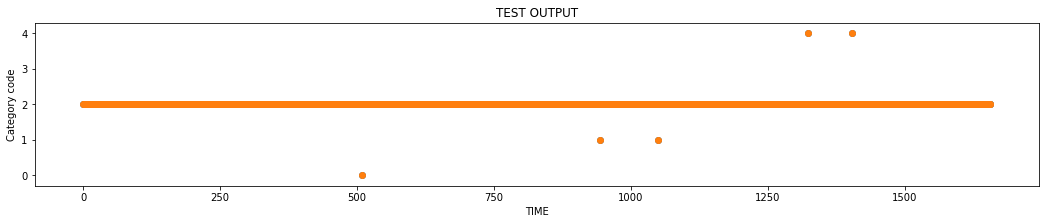

In [14]:
# y_data = [out[i] for i in (keep)]
# x_data = [i for i in range(len(keep))]
y_data = [i for i in (out)]
x_data = [i for i in range(len(out))]
plt.rcParams["figure.figsize"] = (18,3)
plt.scatter(x_data, y_data, label='prediction')
plt.scatter(x_data, y_data, label='prediction')
plt.xlabel('TIME')
plt.ylabel('Category code')
plt.title('TEST OUTPUT')
# plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


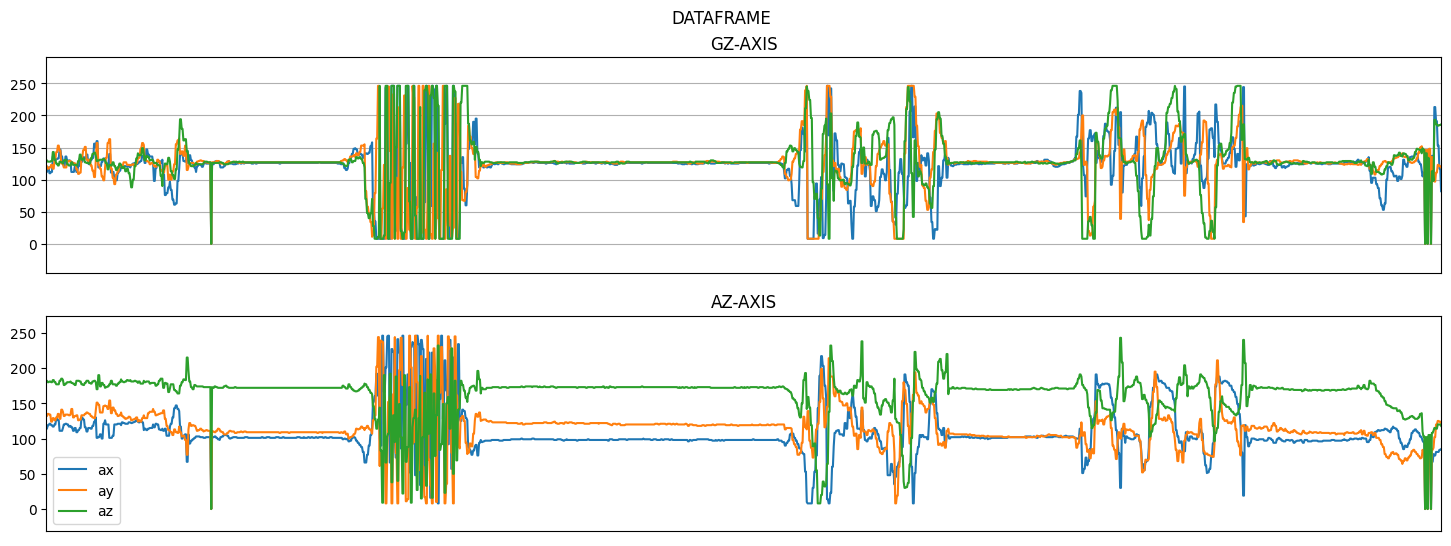

In [11]:
df_copy['time']=[i+1 for i in range(df.shape[0])]
plot_full_v2(df_copy)